# Product Description Generator




#### Data Dictionary<a class="anchor" id="Data-Dictionary"></a>

<https://www.kaggle.com/datasets/sachsene/amazons-advertisements> from <https://github.com/paschok/Diploma>

The dataset size is 252 MB and comprises of 2.7 million ad texts (each is one row in the csv) in 445 files across 40 categories like electronics, wearables, automotive, appliances, fashion, tools, accessories etc.

#### Input Data
Decided to use only 2 domains (electronics and wearables) since I could only use about 10-15K rows of training data without running into resource constraints.

* [`amazon_tv_wearable_12k_holidays.csv`](../data/amazon_tv_wearable_12k_holidays.csv): Ad text data from amazon.com shopping

**Samples of ad text:**

Sony SWR50 SmartWatch 3 Transflective Display Watch [Black]  
Sony SmartWatch US version 1 Android Bluetooth USB Retail Box  
Sony HDRAS20/B Action Video Camera  
Sony DVPSR510H DVD Player, with HDMI port (Upscaling)  
Sony UBP-X700 4K Ultra HD Blu-Ray Player  
Sony STRDH590 5.2 multi-channel 4k HDR AV Receiver with Bluetooth
Sony BDPS3700 Streaming Blu-Ray Disc Player with Wi-Fi (Black)  
Apple Watch Series 3 (GPS), 42mm Space Gray Aluminum Case with Black Sport Band - MQL12LL/A (Renewed)  
Apple Watch Series 4 (GPS + Cellular, 40mm) - Gold Aluminium Case with Pink Sand Sport Band (Renewed)  
Apple Watch Screen Protector [2 Pack] Premium 3D Tempered Glass Screen Protector for iWatch 42mm Series 3 2 1-[Full Coverage][HD Clear][Scratch-Resistant][Anti Bubble]  
Samsung Gear S2 Smartwatch - Dark Gray  
Samsung HMD Odyssey+ Windows Mixed Reality Headset with 2 Wireless Controllers 3.5" Black (XE800ZBA-HC1US)  
Samsung Galaxy Watch (42mm) Smartwatch (Bluetooth) Android/iOS Compatible -SM-R810 (Rose Gold)  
Samsung Galaxy Fit Black (Bluetooth), SM-R370NZKAXAR ‚Äì US Version with Warranty  
Samsung Galaxy Smartwatch (46mm) Silver (Bluetooth), SM-R800NZSAXAR ‚Äì US Version with Warranty  
GE Universal Remote Control for Samsung, Vizio, LG, Sony, Sharp, Roku, Apple TV, RCA, Panasonic, Smart TVs, Streaming Players, Blu-ray, DVD, Simple Setup, 4-Device, Graphite, 33711  
Dell Mobile Projector M318WL 500 ANSI lumens WXGA (1280 x 800) 16:10  
Full Motion Tilt, Pan, Swivel Desktop Mount for 32" Samsung, LG, Dell, ViewSonic, HP LED TV/Monitor  
Casio WSD-F10 Smart Outdoor Watch  
Casio Men's 'Pro Trek' Resin Outdoor Smartwatch, Color:Orange (Model: WSD-F20-RGBAU)  
[5-Pack] For Casio GST-B100 Watch Screen Protector,Full Coverage Screen Protector for GST-B100 / GST-B100-1ACR/GST-B100X-1AJF/GST-B100D-1ACR HD Clear Anti-Bubble and Anti-Scratch  
AmazonBasics USB 3.0 to 10/100/1000 Gigabit Ethernet Internet Adapter  
AmazonBasics Amplified Indoor/Outdoor TV Antenna - 60 Mile Range  
AmazonBasics TV Trolley for 24-43" TVs with Swivel Feature  
NVIDIA SHIELD TV Gaming Edition | 4K HDR Streaming Media Player with GeForce NOW  
Geekworm NVIDIA Jetson Nano WiFi Adapter Dual Band Wireless USB 3.0 Adapter 5GHz and 2.4GHz 1200Mbps Network Card  






In [ ]:
onGoogleColab = True
useGPU = True
useTPU = False

max_rows= 15000
batch_size = 4096
layer_size = 128

In [ ]:
if onGoogleColab:

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/drive/MyDrive/AdTextGeneration-main/code
  %pwd

Mounted at /content/drive
[Errno 2] No such file or directory: 'drive/drive/MyDrive/AdTextGeneration-main/code'
/content


In [ ]:
if onGoogleColab:
  !pip install transformers

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import datetime as dt
#import re

#from preprocess_tokenize import * # helper .py file
#from modeling_functions import * # helper .py file
from collections import Counter

import tensorflow as tf

from tensorflow.keras.utils import Sequence

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential

from tensorflow.keras.callbacks import EarlyStopping

from transformers import pipeline

#### Read input data from the amazon ad text file.   
This contains data from Amazon ads for two categories Electronics and Wearables. I also added a few rows for holiday related special deals and discounts to support additional ad formats.

In [ ]:
# Read data

file_name = "/content/drive/MyDrive/AdTextGeneration-main/data/amazon_tv_wearable_12k_holidays.csv"

df_ads = pd.read_csv(file_name)

df_ads.head() # contains just one column


,ad
0,Spigen Rugged Armor Pro Designed for Apple Wat...
1,Xiaomi Mi Band 4
2,LK 6 Pack Screen Protector for Apple Watch (38...
3,KOLEK Floral Bands Compatible with Apple Watch...
4,Amazfit Bip Smartwatch by Huami with All-Day H...


In [ ]:
df_ads.describe()

,ad
count,13070
unique,12880
top,Holiday specials on
freq,13


### Data Cleanup
- only nulls and dups needed to be cleaned up


In [ ]:
df_ads.dropna(inplace=True) # drop the nulls, if any

In [ ]:
df_ads.loc[df_ads["ad"].str.contains("Casio")].head()

,ad
1882,Casio Men's 'Pro Trek' Resin Outdoor Smartwatc...
2265,[5-Pack] For Casio DW-5600 /DW5600 Watch Scree...
2699,[5-Pack] for Casio MDV106-1A Watch Screen Prot...
2968,23mm Rubber Watch Band Strap Fits Casio Replac...
3268,SIKAI Protective Bumper for Casio G-Shock GW56...


In [ ]:
len( set( df_ads["ad"] ) ) # 12880 unique rows out of 13070

12880

In [ ]:
# Remove the dups and store back in df
df_ads = pd.DataFrame(list( set( df_ads["ad"] ) ), columns = ["ad"] )
df_ads.head()


,ad
0,"Threeeggs for Fibit Versa Charger, Replacement..."
1,NANW Compatible with Garmin Vivoactive 3 Charg...
2,"Lesampo for Apple Watch Band 38mm 42mm,Compati..."
3,AtmosFearFX Zombie Invasion Halloween DVD and ...
4,RCA VH127N Antenna Rotator Cable


#### EDA

- Only one column of information



Text(0.5, 1.0, 'Frequency of number of characters per ad')

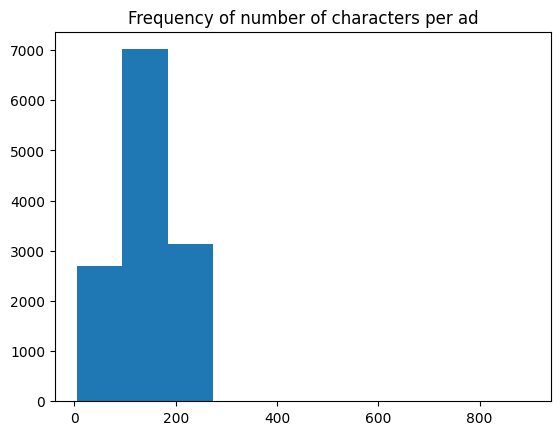

In [ ]:
# Look at the data

plt.hist([len(s) for s in df_ads["ad"]]);
plt.title("Frequency of number of characters per ad")


In [ ]:
# add column with len of ad text

df_ads["num_chars"] = [len(s) for s in df_ads["ad"]]

df_ads['num_chars'].head()


0     89
1    194
2    161
3    102
4     32
Name: num_chars, dtype: int64

In [ ]:
df_ads['num_chars'].describe()

count    12880.000000
mean       140.190295
std         51.297043
min          6.000000
25%        105.000000
50%        152.000000
75%        183.000000
max        896.000000
Name: num_chars, dtype: float64

In [ ]:
df_ads['num_chars'].value_counts()

num_chars
198    272
199    270
200    268
197    237
196    205
      ... 
896      1
213      1
325      1
205      1
233      1
Name: count, Length: 229, dtype: int64

In [ ]:
# See long ads
pd.set_option ('display.max_colwidth', 350)

df_ads.loc[df_ads['num_chars'] > 300]

,ad,num_chars
2271,NEW Remote fit for VIZIO E320i-B0 E390i-A1 E401i-A2 E480i-B2 E470i-A0 E480-B2 E500D-A0 E291IA1 E320IB0 E390IA1 E401IA2 E550I-B2 E470i-A0 E480IB2 E500DA0 E500I-A1 E550I-A0 E420I-A0 E390I-A1 E320I-A0 E241I-A1 E470I-A0-B E420I-A0-B E390I-A1B E241I-A1B E500I-B1E E420i-A0 E320i-A0 E320I-A2 E322AR E422AR E502AR and most App internet LCD and LED TV---...,372
5170,"Mount-It! MI-1121M Slim Tilt TV Wall Mount Bracket for LED LCD Plasma Flat Screen Panels for 32‚Äù to 65‚Äù (Many from 20-75‚Äù) up to VESA 600 x 400 and 130 lbs Low Profile. 0-15 Degree Forward Adjustable Tilting and Leveling Bubble Fits Samsung, Sony, LG Sharp, Insignia, Vizio, Haier 26, 28, 32, 40, 42, 48, 49, 50, 51, 52, 55, 60, 65 inch TV,...",352
5725,Brand NEW Original OLEVIA RC-LTL RCLTL Remote for 219H 226T 226V 227V 232S 232V 237T 237V 242V 247T OLEVIA 232-T12 OLEVIA 232S OLEVIA 232V OLEVIA 237-S11 OLEVIA 237-T11 OLEVIA 237-T12 OLEVIA 237T OLEVIA 237V OLEVIA 242FHDTV OLEVIA 242TFHD OLEVIA 242V OLEVIA 242V78650 OLEVIA 247T OLEVIA 247TFHD OLEVIA 252T OLEVIA 255T OLEVIA 265T OLEVIA 265TFHD ...,896
5896,"Original TV remote control for LG 3D AKB73615362=AKB73615397 *UNIVERSAL* 100% replacement for AKB73615303, AKB73615397 and AKB73756542. HIGH QUALITY Remote. It is a perfect solution if you dont want to use LG MAGIC AN-MR400 remote. Suitable models: AKB73615303, AKB73615362, AKB73615302, AKB73756542, AKB73615361, AKB73615362",325
6797,New ELEMENT TV Remote for ELDFW406 ELCFT262 ELDFW322 ELCFW326 ELCFW329 ELDFT404 ELCFW328 ELDFW464 ELDFT465J ELDFQ501J ELEFQ501J ELGFW601 ELDFW501 ELEFW193 ELEFJ191 ELEFT195 ELEFW195 ELEFS191 ELEFT193 ELEFJ243 ELEFS241 ELEFW264 ELEFT281 ELEFW325 ELEFT326 ELEFS321 ELEFJ321 ELEFT406 ELEFQ402 ELEFW401A ELEFQ462 ELEFT466 ELEFW462 ELEFC461 ELEFC463JA...,470
7575,"LG Electronics AN-MR400G/H Magic Motion Remote Control with Browser Wheel for 2013 Year Smart Tvs (Worldwide use, English Keypad) also known as ANMR400. The TV remote AN-MR400 is compatible with the following LG Smart TV series.2013 LED LCD Smart TVs: 42LA6650, 47LA6900, 47LA7400, 50LA6900, 55LA6205, 55LA6900, 55LA7400, 60LA7400, EA9800, LA9700...",744
8652,"Brand NEW original seiki SEIKI TV Remote for SEIKI LC-32GC12F LC-46G68 SC552GS SC324FB SC32HT04 SE32HS01 SE65FY18 SE60GY24 SE65JY25 SE19HT01 SE40FY19 SE50UY04 LE-46GCA LE-55G77E SE39UY04 SE47FY19 LE-32SCL-C SE55UY04 SC22HY07 TV REMOTE----Original remote; do not any setting, only put into battery can work!",306
10168,New RCA Replaced remote RC-RCA1 fit for RCA WD11452 WD12143 WD12372 WD11392 WD12422 WD12192 WD11442 WD12101 WD12492 WD12021 RCA 46LB45RQ LED39B45RQ 26LA30RQD 32LA30RQ 32LA30 LED42C45RQ 46LB45RQ 46LB45RQ LED50B45RQ RE20QP80 26LARQD LED30B30RQ 40LA45RQ LED42C45 32LA30RQD LED32B30RQ LED46A55R120Q 42PA30RQ RCA RE20QP80 LCD LED TV REMOTE CONTROL,342
11513,Brand NEW Original INSIGNIA TV remote control NS-RC4NA-14 RC4NA14 Remote For NS-28ED200NA14 NS-50D400NA14 NS-19ED200NA14 55E4400A14 NS-58E4400A14 NS-24E400NA14 NS-60E4400A14 NS-65E4400A14 NS-50L440NA14 NS-46D400NA14 NS-65D4400A14 NS-22E400NA14 NS-46L400NA14 NS-46E440NA14 NS-32E2000A14 NS-39D400NA14 NS-32DD2000A14 NS-39L400NA14 NS-55E4400A14 NS-...,426
11549,NEW SEIKI TV Remote control for SEIKI SE55GY19 SE65UY04 SE22FE01 SE65GY25 SE40FY27 SE32FY22 TV SE24FE01-W SE19HE01 SE39HE02 LC-32G82 SE24FT01 SE20HS04 SE26HQ04 SE50FY28 SC151FS SC241FS LC24G82 LC22G82 SC221FS SC261FS SC262FS SC32HT04 SC371TS SC391TS LC-40G81 SC461TS SC501TS SC552GS SC601GS SC601US SC601TS SE131FS SE191FS SE221FS SE222FS SE22HY0...,747


In [ ]:
# Create column with  number of words

df_ads['num_words'] = [ len(s.strip().split(" ")) for s in df_ads['ad']]


In [ ]:
df_ads.head()

,ad,num_chars,num_words
0,"Threeeggs for Fibit Versa Charger, Replacement Charging Dock for Fitbit Versa Smart Watch",89,13
1,"NANW Compatible with Garmin Vivoactive 3 Charger Cable, 3.3ft Retractable USB Charging Station Dock with Data Sync Silicone Dust Plug for Vivoactive 3 / Fenix 5 5S 5X / Forerunner 935 Smartwatch",194,32
2,"Lesampo for Apple Watch Band 38mm 42mm,Compatible with Apple Watch 40mm 44mm Series4 Series3 Series2,Fit for iWatch Strap Nylon Sport Loop Bands, Soft Breathable",161,24
3,AtmosFearFX Zombie Invasion Halloween DVD and Reaper Brothers High Resolution Window Projection Screen,102,13
4,RCA VH127N Antenna Rotator Cable,32,5


In [ ]:
df_ads['num_words'].describe()


count    12880.000000
mean        21.238898
std          7.971833
min          1.000000
25%         16.000000
50%         22.500000
75%         27.000000
max        131.000000
Name: num_words, dtype: float64

In [ ]:
df_ads["num_words"].sum()  # total words in corpus: 30,994,101: 31M with the full dataset!


273557

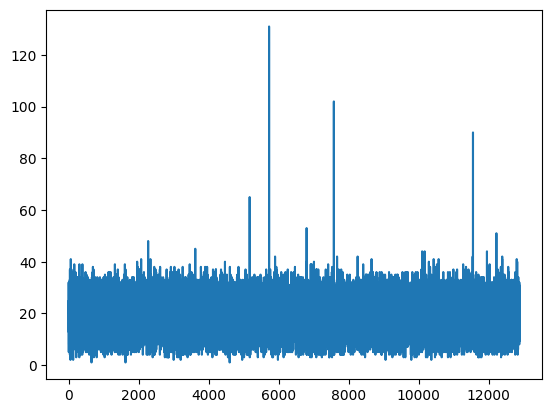

In [ ]:
#re_text = re.sub(r"\S*\d\S*", '', joined_text).strip()
plt.plot(df_ads['num_words']);


In [ ]:
# Keeping only 10% of df_ads for validation data

df_ads_test = df_ads.sample(frac = 0.1, random_state=42)

# Create train df by dropping the test df rows

df_ads_train = df_ads.drop(df_ads_test.index)

In [ ]:
df_ads_train.head()

,ad,num_chars,num_words
0,"Threeeggs for Fibit Versa Charger, Replacement Charging Dock for Fitbit Versa Smart Watch",89,13
1,"NANW Compatible with Garmin Vivoactive 3 Charger Cable, 3.3ft Retractable USB Charging Station Dock with Data Sync Silicone Dust Plug for Vivoactive 3 / Fenix 5 5S 5X / Forerunner 935 Smartwatch",194,32
2,"Lesampo for Apple Watch Band 38mm 42mm,Compatible with Apple Watch 40mm 44mm Series4 Series3 Series2,Fit for iWatch Strap Nylon Sport Loop Bands, Soft Breathable",161,24
3,AtmosFearFX Zombie Invasion Halloween DVD and Reaper Brothers High Resolution Window Projection Screen,102,13
4,RCA VH127N Antenna Rotator Cable,32,5


In [ ]:
df_ads_test.reset_index( drop = True, inplace = True)
df_ads_test.head()

,ad,num_chars,num_words
0,"KuToo Compatible with Samsung Galaxy Watch (42mm) Bands, Leather Glitter Wristband Strap Band Replacement for Galaxy Watch (3D Glitter Black)",141,20
1,"Yealink Wireless USB Wi-Fi Adapter, Dual Band 802.11ac (WF50)",61,9
2,Onkyo TX-RZ720 THX-Certified 7.2-Channel 4K Network A/V Receiver,64,8
3,MYHGRC Universal TV Remote Control Replacement Television Remote Control RC All Function for Samsung Smart TV BN59-01199F,121,17
4,Replacement Bands and Straps Compatible with Garmin Forerunner 735XT 630 620 235 230 220 GPS Running Watch - 8pcs,113,19


In [ ]:
#df_ads_test.drop(columns=['index'], inplace=True )
df_ads_test

,ad,num_chars,num_words
0,"KuToo Compatible with Samsung Galaxy Watch (42mm) Bands, Leather Glitter Wristband Strap Band Replacement for Galaxy Watch (3D Glitter Black)",141,20
1,"Yealink Wireless USB Wi-Fi Adapter, Dual Band 802.11ac (WF50)",61,9
2,Onkyo TX-RZ720 THX-Certified 7.2-Channel 4K Network A/V Receiver,64,8
3,MYHGRC Universal TV Remote Control Replacement Television Remote Control RC All Function for Samsung Smart TV BN59-01199F,121,17
4,Replacement Bands and Straps Compatible with Garmin Forerunner 735XT 630 620 235 230 220 GPS Running Watch - 8pcs,113,19
...,...,...,...
1283,ieGeek 3.5mm Screen-to-Screen Audio-Video AV to AV Cable for ieGeek Portable DVD Player,87,13
1284,"Smartby Replaced LG AKB73975702 Smart LED HDTV Remote Control Replaces AKB74475401, AKB73975701 & AGF76631042",109,14
1285,Yehua WiFi Display Dongle HDMI 1080P Receiver Wireless Screen Mirroring Adapter for TV from Phone to Big Screen Support Miracast Airplay DLNA TV Stick for Android/Mac/iOS/Windows,178,26
1286,Case-Mate - Apple Watch Bumper Case - 38mm - NAKED TOUGH - Series 3 Apple Watch - Clear,87,18


In [ ]:
# Convert from df to string for modeling.


ads_str_train = df_ads_train["ad"].to_string(header= False, index=False, max_rows=max_rows)
ads_str_test = df_ads_test["ad"].to_string(header= False, index=False, max_rows=max_rows)


In [ ]:

len(ads_str_train), len(ads_str_test)

(4068791, 452087)

In [ ]:

idx = 463575
print( ads_str_train[idx:idx+200])

                                               Kenwood KRA-27M UHF Helical Antenna, 440-490 MHz
                                                                                                        


In [ ]:
# Find all the occurrences of Sony. we printed only a few (every 20th one)
idx = 0
str_to_find = "Sony"
cnt = ads_str_train.count( str_to_find)

for i in range (cnt):
    idx = ads_str_train.find( str_to_find, idx+1)
    if i // 20 == 0: # limit the number printed
        print( ads_str_train[idx:idx+200])


Sony RMF-TX300U Smart TV Remote with Netflix and Google Play (RMFTX300U / 149331811)
                                                                                                                   
Sony High Res Audio - Built-in WiFi - Multi System Region Free Blu Ray Disc DVD Player
                                                                                                                 
Sony HDRAS20/B Action Video Camera
                                                                                                                                                                     
Sony SLV-D380P DVD/VCR Tunerless Progressive Scan DVD/VHS Combo Player (2009 Model), Black
                                                                                                             
Sony LG Huawei Android Smartphones (Black)
                                                                                                                                                         

In [ ]:

idx = 0
str_to_find = "Sony"
cnt = ads_str_test.count( str_to_find)

for i in range (cnt):
    idx = ads_str_test.find( str_to_find, idx+1)
    #print( ads_str_test[idx:idx+200])


### For LSTM, we need to:
1. Tokenize - split the description text into tokens (words)
2. Remove dups - create a list of distinct tokens
3. Since the model needs numeric values (not words), we map the tokens into numeric ids (used a simple index in the list as the ids).
(The Keras Embedding layer does a semantics vectorization of the tokens, more later).  
And we maintain a dict to map the ids back into the tokens.  

4. Create sequences of input tokens of length max_len (used 4, but configurable), followed by the 'labeled' token (or next word).


In [ ]:
import re

class ProcessText:
    def __init__(self, input_text, token2ind=None, ind2token=None):

        self.content = input_text
        self.tokens, self.tokens_distinct = self.tokenize()

        if token2ind != None and ind2token != None:
            self.token2ind, self.ind2token = token2ind, ind2token
        else:
            self.token2ind, self.ind2token = self.create_word_mapping(self.tokens_distinct)

        # indexes of the tokens in the input str
        self.tokens_ind = [self.token2ind[token] if token in self.token2ind.keys() else self.token2ind['<| unknown |>']
                           for token in self.tokens]

    def __repr__(self):
        return self.content

    def __len__(self):
        return len(self.tokens_distinct)

    @staticmethod
    def create_word_mapping(values_list):
        values_list.append('<| unknown |>')

        # Use index in the list as the numeric id
        value2ind = {value: ind for ind, value in enumerate(values_list)}
        ind2value = dict(enumerate(values_list))
        return value2ind, ind2value

    def preprocess(self):
        punctuation_pad = '!?.,:-;'
        punctuation_remove = '"()_\n'

        self.content_preprocess = re.sub(r'(\S)(\n)(\S)', r'\1 \2 \3', self.content)
        self.content_preprocess = self.content_preprocess.translate(str.maketrans('', '', punctuation_remove))
        self.content_preprocess = self.content_preprocess.translate(
            str.maketrans({key: ' {0} '.format(key) for key in punctuation_pad}))
        self.content_preprocess = re.sub(' +', ' ', self.content_preprocess)
        self.content = self.content_preprocess.strip()

    def tokenize(self):
        self.preprocess()
        tokens = self.content.split(' ')
        return tokens, list(set(tokens))

    def tokens_info(self):
        print('total tokens: %d, distinct tokens: %d' % (len(self.tokens), len(self.tokens_distinct)))
        return len(self.tokens), len(self.tokens_distinct)




In [ ]:

import re
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical



class Sequences():
    def __init__(self, text_object, max_len, step):
        self.tokens_ind = text_object.tokens_ind
        self.max_len = max_len
        self.step = step
        self.sequences, self.next_words = self.create_sequences()

    def __repr__(self):
        return 'Sequence object of max_len: %d and step: %d' % (self.max_len, self.step)

    def __len__(self):
        return len(self.sequences)

    def create_sequences(self):
        sequences = []
        next_words = []

        for i in range(0, len(self.tokens_ind) - self.max_len, self.step):
            sequences.append(self.tokens_ind[i: i +self.max_len])
            next_words.append(self.tokens_ind[ i +self.max_len])
        return sequences, next_words

    def sequences_info(self):
        print('number of sequences of length %d: %d' % (self.max_len, len(self.sequences)))

class TextDataGenerator(Sequence):
#class TextDataGenerator(tensorflow.keras.utils.Sequence):

    def __init__(self, sequences, next_words, sequence_length, vocab_size, batch_size=32, shuffle=True, embedding=False):
        self.batch_size = batch_size
        self.sequences = sequences
        self.next_words = next_words
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.shuffle = shuffle
        self.embedding = embedding
        self.X = None
        self.y = None
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.sequences) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        sequences_batch = [self.sequences[k] for k in indexes]
        next_words_batch = [self.next_words[k] for k in indexes]

        if self.embedding:
          X = np.array(sequences_batch)
          y = to_categorical(next_words_batch, num_classes=self.vocab_size)
            # y = keras.utils.to_categorical(next_words_batch, num_classes=self.vocab_size)
        else:
          X, y = self.__data_generation(sequences_batch, next_words_batch)
        self.X = X
        self.y = y
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.sequences))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, sequences_batch, next_words_batch):
        X = np.zeros((self.batch_size, self.sequence_length, self.vocab_size), dtype=bool)
        y = np.zeros((self.batch_size, self.vocab_size), dtype=bool)

        for i, seq in enumerate(sequences_batch):
            for j, word in enumerate(seq):
                X[i, j, word] = 1
                y[i, next_words_batch[i]] = 1

        self.X = X
        self.y = y

        return X, y

class ModelPredict():
    def __init__(self, model, prefix, token2ind, ind2token, max_len, embedding=False):
        self.model = model
        self.token2ind, self.ind2token = token2ind, ind2token
        self.max_len = max_len
        self.prefix = prefix
        self.tokens_ind = prefix.tokens_ind.copy()
        self.embedding = embedding

    def __repr__(self):
        return self.prefix.content

    def single_data_generation(self):
        single_sequence = np.zeros((1, self.max_len, len(self.token2ind)), dtype=bool)
        prefix = self.tokens_ind[-self.max_len:]

        for i, s in enumerate(prefix):
            single_sequence[0, i, s] = 1
        return single_sequence

    def model_predict(self):
        if self.embedding:
          model_input = np.array(self.tokens_ind).reshape(1,-1)
        else:
          model_input = self.single_data_generation()
        return self.model.predict(model_input)[0]

    @staticmethod
    def add_prob_temperature(prob, temperature=1):
        prob = prob.astype(float)
        prob_with_temperature = np.exp(np.where(prob == 0, 0, np.log(prob + 1e-10)) / temperature)
        prob_with_temperature /= np.sum(prob_with_temperature)
        return prob_with_temperature

    @staticmethod
    def reverse_preprocess(text):
        text_reverse = re.sub(r'\s+([!?"\'().,;-])', r'\1', text)
        text_reverse = re.sub(' +', ' ', text_reverse)
        return text_reverse

    def return_next_word(self, temperature=1, as_word=False):
        prob = self.model_predict()

        prob_with_temperature = self.add_prob_temperature(prob, temperature)
        next_word = np.random.choice(len(prob_with_temperature), p=prob_with_temperature)

        if as_word:
            return self.ind2token[next_word]
        else:
            return next_word

    def generate_sequence(self, k, append=False, temperature=1):
        for i in range(k):
            next_word = self.return_next_word(temperature=temperature)
            self.tokens_ind.append(next_word)
        return_tokens_ind = self.tokens_ind
        return_tokens_ind = ' '.join([self.ind2token[ind] for ind in return_tokens_ind])

        if not append:
            self.tokens_ind = self.prefix.tokens_ind.copy()

        return self.reverse_preprocess(return_tokens_ind)

    def bulk_generate_sequence(self, k, n, temperature=1):
        for i in range(n):
            print(self.generate_sequence(k, temperature=temperature))
            print('\n')




In [ ]:
# Sequences of length max_len=4 and step=3

max_len = 4
step = 3

# Tokenize
text_train = ProcessText( ads_str_train)
text_test = ProcessText( ads_str_test)

# Print number of tokens
text_train.tokens_info()
text_test.tokens_info()

# Create sequences
seq_train = Sequences(text_train, max_len, step)
seq_train.sequences_info()

# Print number of sequences
seq_test = Sequences(text_test, max_len, step)
seq_test.sequences_info()


total tokens: 289679, distinct tokens: 22658
total tokens: 32106, distinct tokens: 5471
number of sequences of length 4: 96559
number of sequences of length 4: 10701


In [ ]:
len( text_train), len( text_test)

(22658, 5471)

In [ ]:
# Print the first ten tokens and their numeric ids

print(text_train.tokens[:10])
print(text_train.tokens_ind[:10], '\n')

# View 2 sequences
np.array(seq_train.sequences[:2])

['Threeeggs', 'for', 'Fibit', 'Versa', 'Charger', ',', 'Replacement', 'Charging', 'Dock', 'for']
[1892, 12244, 20185, 14482, 13204, 17941, 19323, 1061, 11464, 12244] 



array([[ 1892, 12244, 20185, 14482],
       [14482, 13204, 17941, 19323]])

#### **Interpretation:**  
Each sequence is of length 4, of which 3 are input tokens (X variable) and the 4th is the output (y). This is a self-supervised learning algorithm, and the beauty is that we don't need an extra step of human intervention to label the data!   

Tokens and their numeric ids:   
['ZAGG', 'InvisibleShield', 'Luxe', 'Screen', 'Protector', 'for', 'Apple', 'Watch', 'Series', '2']  
[3393, 963, 9601, 18828, 12556, 10430, 5129, 544, 9532, 9217]   
3393 is the numeric id for Zagg; 963 is the numeric id for InvisibleShield etc...   

Sequence:   
array([[ 3393,   963,  9601, 18828],  
       [18828, 12556, 10430,  5129]])  
Sequence[0] contains: Zagg Invisible Luxe Screen  
Sequence[1] contains Screen Protector for Apple  


#### TextDataGenerator is a subclass of Keras's Sequence superclass used to generate the sequences required during fit.  
TextDataGenerator is called at each step during the model.fit and it returns a batch of sequences containing the X and y variables as defined above.     
  
X is a sparse matrix of shape: batch_size, sequence len, distinct token ids and  
y is of shape: batch_size, distinct token ids

In [ ]:
# Create generator for training data

params = {
  'sequence_length': max_len,
  'vocab_size': len(text_train),
  'batch_size': batch_size,
  'shuffle': True
}

train_generator = TextDataGenerator(seq_train.sequences, seq_train.next_words, **params)

In [ ]:
# Create generator for testing data

params_test = {
  'sequence_length': max_len,
  'vocab_size': len(text_test),
  'batch_size': batch_size,
  'shuffle': True
}

test_generator = TextDataGenerator(seq_test.sequences, seq_test.next_words, **params_test)

In [ ]:
len(train_generator), train_generator.batch_size


(23, 4096)

In [ ]:

len(test_generator), test_generator.batch_size


(2, 4096)

### Model architecture:
RNN model with LSTM input layer (with or without Embedding Layer) of 20k nodes (vocabulary size), Dropout to avoid overfitting and output layer using softmax activation.   
<font color="red">The output shape is the size of the vocabulary (20k)</font> which is very different from the 2 in a binary classification or 10 in the MNIST image 0-9 digit classification!

In [ ]:
def lstm_model(sequence_length, vocab_size, layer_size, embedding=False):

  # 4, 20k, 128
  print( sequence_length, vocab_size, layer_size)

  model = Sequential()
  if embedding:
    model.add(Embedding(vocab_size, layer_size))
    model.add(LSTM(layer_size))
  else:
    model.add(LSTM(layer_size, input_shape=(sequence_length, vocab_size)))

  ## Second LSTM layer passes outputs forward to next layer
  #model.add(LSTM(layer_size, return_sequences=False))
  #model.add(Dense(layer_size, activation = 'relu', kernel_regularizer=l2(0.001)))

  # Regularization
  model.add(Dropout(0.3))

  model.add(Dense(vocab_size, activation='softmax')) #output shape is equal to vocab size
  return model




####
Create the model and compile with optimizer Adam and metrics applicable for text generation:   
loss='categorical_crossentropy'   
metrics = ['CategoricalAccuracy', 'CategoricalCrossentropy', 'TopKCategoricalAccuracy', 'CategoricalHinge'])



In [ ]:

# Set useTPU (in global section at the top) to True to use the TPU.

if useTPU:

  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)

  strategy = tf.distribute.TPUStrategy(tpu)
  #strategy = tf.distribute.experimental.TPUStrategy(tpu) # experimental is deprecated

  print("REPLICAS: ", strategy.num_replicas_in_sync)

  #
  # Create model with TPU strategy
  #
  with strategy.scope():

    print( "Doing create model with TPU")
    model = lstm_model(max_len, len(text_train), layer_size)
    optimizer = tf.keras.optimizers.Adam(learning_rate =0.01)
    #optimizer = tf.keras.optimizers.RMSprop(learning_rate =0.01)


    model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics = ['CategoricalAccuracy', 'CategoricalCrossentropy', 'TopKCategoricalAccuracy', 'CategoricalHinge'])

else:

  print( "Doing create model without TPU")
  model = lstm_model(max_len, len(text_train), layer_size)

  # Tried both RMSprop/Adam as optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate =0.01)
#  optimizer = tf.keras.optimizers.RMSprop(learning_rate =0.01)

  # Metrics applicable for text generation
  model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics = ['CategoricalAccuracy', 'CategoricalCrossentropy', 'TopKCategoricalAccuracy', 'CategoricalHinge'])


Doing create model without TPU
4 22658 128


In [ ]:
model.summary() # 14 million trainable params!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               11666944  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 22658)             2922882   
                                                                 
Total params: 14589826 (55.66 MB)
Trainable params: 14589826 (55.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model.fit
train_generator is called at each step and it returns a batch of X and y.   
Using the test_generator should work for the validation data, but it gives an error.

In [ ]:
def model_fit( num_epochs):

  history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=num_epochs,
#         validation_data = test_generator,
          verbose=1)

  return history


Baseline metrics: No training; 1 epoch

In [ ]:
# get baseline first
baseline_history = model_fit( 1 )


23/23 [==============================] - 32s 939ms/step - loss: 8.1453 - categorical_accuracy: 0.0509 - categorical_crossentropy: 8.1453 - top_k_categorical_accuracy: 0.1518 - categorical_hinge: 1.0212


In [ ]:
#baseline_history.history

In [ ]:
# train model

history = model_fit(5)


Epoch 1/5
23/23 [==============================] - 15s 607ms/step - loss: 6.8156 - categorical_accuracy: 0.0451 - categorical_crossentropy: 6.8156 - top_k_categorical_accuracy: 0.1610 - categorical_hinge: 1.0386
Epoch 2/5
23/23 [==============================] - 15s 629ms/step - loss: 6.6172 - categorical_accuracy: 0.0522 - categorical_crossentropy: 6.6172 - top_k_categorical_accuracy: 0.1692 - categorical_hinge: 1.0342
Epoch 3/5
23/23 [==============================] - 20s 852ms/step - loss: 6.4849 - categorical_accuracy: 0.0589 - categorical_crossentropy: 6.4849 - top_k_categorical_accuracy: 0.1726 - categorical_hinge: 1.0357
Epoch 4/5
23/23 [==============================] - 15s 629ms/step - loss: 6.2285 - categorical_accuracy: 0.0758 - categorical_crossentropy: 6.2285 - top_k_categorical_accuracy: 0.2070 - categorical_hinge: 1.0404
Epoch 5/5
23/23 [==============================] - 15s 601ms/step - loss: 5.8869 - categorical_accuracy: 0.1146 - categorical_crossentropy: 5.8869 - top

In [ ]:
# Save the model for inference purposes
model.save('/content/drive/MyDrive/AdTextGeneration-main/data/lstm_model_13krows_batch4k.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# prompt: sony

idx = 0
str_to_find = "Sony"
cnt = ads_str_train.count( str_to_find)

for i in range (cnt):
    idx = ads_str_train.find( str_to_find, idx+1)
    if i // 20 == 0: # limit the number printed
        print( ads_str_train[idx:idx+200])



Sony RMF-TX300U Smart TV Remote with Netflix and Google Play (RMFTX300U / 149331811)
                                                                                                                   
Sony High Res Audio - Built-in WiFi - Multi System Region Free Blu Ray Disc DVD Player
                                                                                                                 
Sony HDRAS20/B Action Video Camera
                                                                                                                                                                     
Sony SLV-D380P DVD/VCR Tunerless Progressive Scan DVD/VHS Combo Player (2009 Model), Black
                                                                                                             
Sony LG Huawei Android Smartphones (Black)
                                                                                                                                                         

### Modeling done!
Evaluate the model performance with graphs and metrics vs baseline

In [ ]:
# Plot loss and accuracy metrics

def plot_metrics(history, title):
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (14,6))

  ## Plot Training & Validation Loss
  ax1.plot(history.history['loss'], label="Loss")
  #ax1.plot(history.history['loss'], label="Training Loss")
  #ax1.plot(history.history['val_loss'], label="Testing Loss")
  ax1.legend();

  ## Plot Training & Validation Accuracy
  ax2.plot(history.history['categorical_accuracy'], label="Categorical Accuracy")
  #ax2.plot(history.history['categorical_accuracy'], label="Training Cat Accuracy")
  #ax2.plot(history.history['val_accuracy'], label="Testing Accuracy")
  ax2.legend();

  ax3.plot(history.history['top_k_categorical_accuracy'], label="Top K Categorical Accuracy")
  #ax3.plot(history.history['top_k_categorical_accuracy'], label="Training TopKCatAccuracy")
  ax3.legend();

  ax4.plot(history.history['categorical_hinge'], label="Categorical_hinge")
  #ax4.plot(history.history['categorical_hinge'], label="Training categorical_hinge")
  ax4.legend();

  plt.suptitle(title);


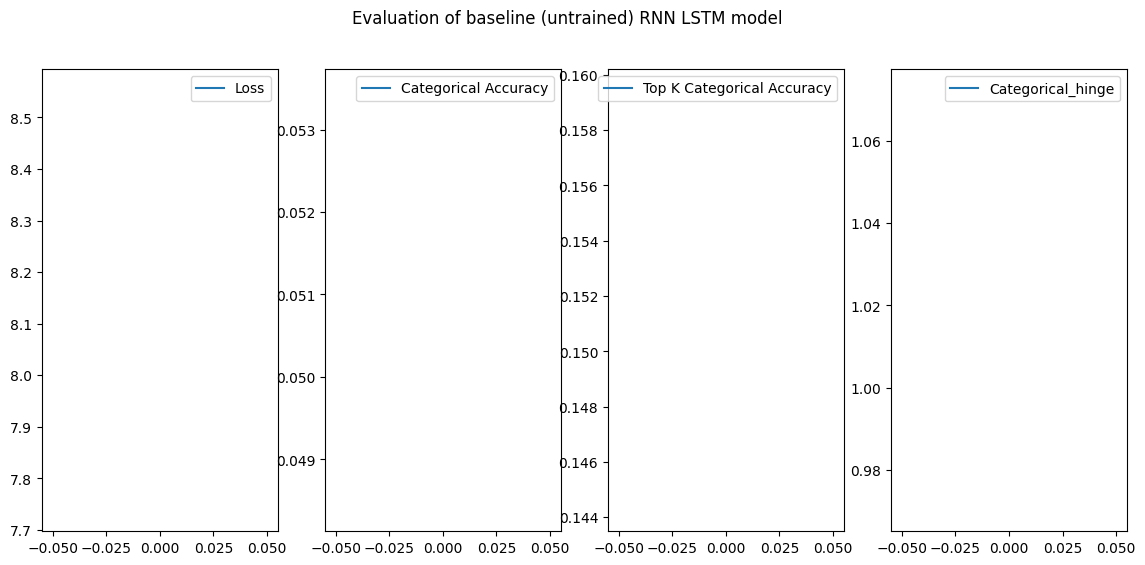

In [ ]:
plot_metrics(baseline_history, "Evaluation of baseline (untrained) RNN LSTM model")
# only 1 epoch so no history for graph


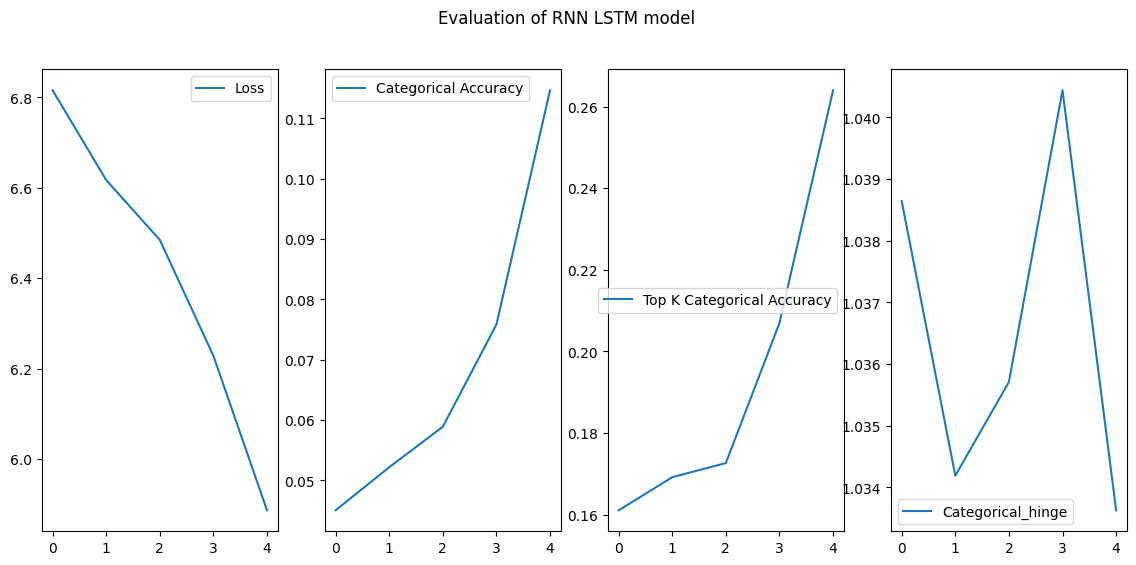

In [ ]:
plot_metrics(history, "Evaluation of RNN LSTM model")

#### **Interpretation:**  
The graphs are trending in the right direction - the loss is decreasing as the epochs increase and the categorical and TopK Categorical Accuracies are increasing.   
They are plateauing as the epochs increase, but maybe with more epochs they could be better.   
Validation data was giving an error so I couldn't plot the validation loss and accuracy which would have helped check for overfitting.


In [ ]:
#model.score()
#train_generator.vocab_size
df_ads_train.shape, df_ads.shape


((11592, 3), (12880, 3))

#### Compute model evaluation metrics

In [ ]:
def evaluate_model(baseline_history, history):

  results_df = pd.DataFrame()

  results_df["max_rows"] = [max_rows]
  results_df["Actual Rows"] = [df_ads_train.shape]
  results_df["batch_size"] = [train_generator.batch_size]

  total_tokens, distinct_tokens = text_train.tokens_info()
  #print( total_tokens, distinct_tokens)

  results_df["total_tokens"] = [total_tokens]
  results_df["distinct_tokens"] = [distinct_tokens]
  results_df["steps_per_epoch"] = [len(train_generator)]

  results_df["Baseline Categorical Accuracy"] = max(baseline_history.history['categorical_accuracy'])
  results_df["Categorical Accuracy"] = max(history.history['categorical_accuracy'])

  results_df["Baseline Categorical Crossentropy"] = min(baseline_history.history['categorical_crossentropy']) #Loss
  results_df["Categorical Crossentropy"] = min(history.history['categorical_crossentropy']) #Loss

  results_df["Baseline Top K Categorical Accuracy"] = max(baseline_history.history['top_k_categorical_accuracy'])
  results_df["Top K Categorical Accuracy"] = max(history.history['top_k_categorical_accuracy'])

  return results_df




#### Write metrics to file

In [ ]:
results_df = evaluate_model(baseline_history,  history)

results_df["Model"]= ["LSTM"]*len(results_df)

# save the metric results to file
results_df.to_csv("/content/drive/MyDrive/AdTextGeneration-main/data/lstm_results_df_holidays.csv")


total tokens: 289679, distinct tokens: 22658


In [ ]:
results_df

,max_rows,Actual Rows,batch_size,total_tokens,distinct_tokens,steps_per_epoch,Baseline Categorical Accuracy,Categorical Accuracy,Baseline Categorical Crossentropy,Categorical Crossentropy,Baseline Top K Categorical Accuracy,Top K Categorical Accuracy,Model
0,15000,"(11592, 3)",4096,289679,22658,23,0.05093,0.11464,8.145301,5.886943,0.151845,0.264012,LSTM


#### **Interpretation:**

Much better than baseline.


### Now comes the fun part! Inference.
Let's generate some text and see what results we get.


In [ ]:
# Specify the input prompt. This can be a few words with keywords for the ad.
# Examples are: Last minute Memorial Day deals on Samsung headphones' or the others commented out below.

input_prefix = 'Last minute Memorial Day deals on Samsung headphones'
#input_prefix = 'Apple watch'
#input_prefix = 'Mothers Day savings on'
#input_prefix = 'Big savings on the new'

#input_prefix = 'Sony TV'
#input_prefix = 'Sony PS3'
#input_prefix = 'Sony Playstation'

token2ind, ind2token = text_train.token2ind, text_train.ind2token
text_prefix = ProcessText(input_prefix, token2ind, ind2token)

#### First instantiate an instance of the class ModelPredict (defined in modeling_functions.py), passing in the input prompt and the trained model.


In [ ]:
pred = ModelPredict(model, text_prefix, token2ind, ind2token, max_len)


### Let's see the generated text for different temperatures.

Temperature controls the randomness of the generated text. A value of 0 makes the engine deterministic, which means that it will always generate the same output for a given input text. A value of 1 makes the engine take the most risks and use a lot of creativity.

#### Temperature sampling is inspired by statistical thermodynamics, where high temperature means low energy states are more likely encountered.
In probability models, logits play the role of energy and we can implement temperature sampling by dividing logits by the temperature before feeding them into softmax and obtaining our sampling probabilities.



In [ ]:
#### generate_sequence calls the trained models's .predict function after converting the input words to their numeric ids
# and vice versa after the models prediction. It also handles temperature.

temperatures = [1, 0.7, 0.4, 0.1]

for temperature in temperatures:
  print('temperature:', temperature)
  print(pred.generate_sequence(30, temperature=temperature))
  print('\n')

temperature: 1
1/1 [==============================] - 0s 28ms/step
Last minute Memorial Day deals on Samsung headphones and DVD Outputs Acrylic Box Anti Compatible for Fitbit Blaze Compatible Stainless Silver Metal Band LCD 2 for for MIFFO 3.. Spring 0- 50UP120 Rail Fin DC40E


temperature: 0.7
1/1 [==============================] - 0s 17ms/step
Last minute Memorial Day deals on Samsung headphones to Vancle, Year's for Apple Watch, Leather Watch, Watch Series 5, 40mm 44mm Link Replacement for Apple Watch S3 Series 4 4 5 4,-


temperature: 0.4
1/1 [==============================] - 0s 18ms/step
Last minute Memorial Day deals on Samsung headphones Compatible, Watch, 44mm,, Samsung,,,,-,,-.-.---- Bluray-- to PH317- Converter


temperature: 0.1
1/1 [==============================] - 0s 25ms/step
Last minute Memorial Day deals on Samsung headphones,,----------------------------




#### **Interpretation:**  
At lower temperature, there may be repitition of words. Typically, results are best with temperature 0.7.   

The ad text generated is decent!
In fact, given that our training data size is not large, the results are a lot better than I had expected.

However, other Generative Pre-trained Transformer models like OpenAI's GPT-3 and Eleuther's GPT-NEO are trained on 800+GB of data and do a really good job of generating text.





### LSTM with Embedding layer

#### Now try with Embedding Layer



In [ ]:
batch_size_emb = batch_size

params_emb = params.copy()
params_emb['embedding'] = True

train_generator_emb = TextDataGenerator(seq_train.sequences, seq_train.next_words, **params_emb)

In [ ]:
# Tried 128, 64 and 16 as vector dimensions, 128 is best.

model_emb = lstm_model(max_len, len(text_train), layer_size, embedding=True)
#model_emb = lstm_model(max_len, len(text_train), 128, embedding=True)

model_emb.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics = ['CategoricalAccuracy', 'CategoricalCrossentropy', 'TopKCategoricalAccuracy', 'CategoricalHinge'])


4 22658 128


In [ ]:
model_emb.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2900224   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 22658)             2922882   
                                                                 
Total params: 5954690 (22.72 MB)
Trainable params: 5954690 (22.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def emb_model_fit(num_epochs):
  history_emb = model_emb.fit(train_generator_emb,
              steps_per_epoch=len(train_generator_emb),
              epochs=num_epochs,
              verbose=1)
  return history_emb


In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:

#get baseline first with just 1 epoch (no training)
#emb_baseline_history = emb_model_fit(1)



StagingError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 225, in _update_step_xla  *
        return self._update_step(gradient, variable)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 233, in _update_step  **
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable embedding/embeddings:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


In [ ]:
#emb_history = emb_model_fit( 100 )


In [ ]:
#model_emb.save('/content/drive/MyDrive/AdTextGeneration-main/data/lstm_model_emb_13k_batch4k.h5')


In [ ]:
#plot_metrics(emb_history, "Evaluation of RNN LSTM model with Embedding ")

#### **Interpretation:**
The graphs are trending in the right direction with significant improvement over baseline


In [ ]:

emb_results_df = evaluate_model(emb_baseline_history,  emb_history)

emb_results_df["Model"]= ["Embed LSTM"]*len(emb_results_df)

results_df_merged = results_df.append(emb_results_df)

# save the metric results to file
results_df_merged.to_csv("/content/drive/MyDrive/AdTextGeneration-main/data/lstm_results_df_holidays.csv")


In [ ]:
# View results
emb_results_df


#### **Interpretation:**

Metrics are much better than baseline
Top K categorical accuracy of 0.95 is really good, though hard to
tell if there is overfitting since there is no comparable validation
data metrics (Keras doesn’t easily support validation data with
Sequences)

In [ ]:
results_df_merged

NameError: name 'results_df_merged' is not defined

#### **Interpretation:**

Metrics for both models are much better than baseline.  
Both perform similarly


In [ ]:
token2ind, ind2token = text_train.token2ind, text_train.ind2token

input_prefix = 'Sony TV'

text_prefix = ProcessText(input_prefix, token2ind, ind2token)

In [ ]:
pred_emb = ModelPredict(model_emb, text_prefix, token2ind, ind2token, max_len, embedding=True)


In [ ]:
temperatures = [1, 0.7, 0.4, 0.1]

for temperature in temperatures:
  print('temperature:', temperature)
  print(pred_emb.generate_sequence(50, temperature=temperature))
  print('\n')

temperature: 1
1/1 [==============================] - 0s 19ms/step
Sony TV 4258 FX970 UN60EH6000 SWM8 Man Bdx3300 CR1 Xs Vivofit/Garmin Iridescent ED047 4Band Virginia LC70LE745U 720p/1080p Honor DELL Bands/Samsung lamp cup EXCHAR FW32D08F J6500 0/2 Black+White+Lime miracast 4/3/2/1& Pinch D48HNE0 Players Extends Trailers 44mm/40mm/42mm/38mm most Unless Definition] JK JM57 VSB200 1090 24mm MITERV Lexmark iPazzPort D6100C/ZA 127 Exford Lucky VL470M SKN6461A


temperature: 0.7
1/1 [==============================] - 0s 29ms/step
Sony TV UN55EH6050 HR44 N5300 Desktop Assembly Bamboo 32LH500B 01041a E220va 2g 38/40/44/42 LC43LE653U Glonass Aeon TX101D Calories MTK6580 UN55H6350AFXZA 40mm/38mm Bravia Helical Pupgang Calling HM59C/ZA Transparent Sarno 4Pack EasyClean 70Inch MSPLIT4R1 onto Magicband DLNA/Airplay 50N7002U DVD's Shure Does EASTECH HUMENN interfaces Balanced PDI Resistant][Anti V555 D40f Xiaom NB 55FS3700 B36 Plded3273a


temperature: 0.4
1/1 [==============================] - 0s

#### Inference under the hood
Dig deep into the calculations of the next word and temperature math. Outputs the top 5 words along with the probabilities to show how temperature affects the next word picked. Look at the probabilities of the possible next words and how temperature determines the selection.

In [ ]:
# Token and ids for the specified Prefix prompt
text_prefix.content, text_prefix.tokens_ind

('Sony TV', [17980, 18367])

In [ ]:
# prepare the data for .predict
#single_sequence_1 = np.zeros((1, max_len, len(token2ind)), dtype=bool)
#prefix_1 = text_prefix.tokens_ind[-max_len:]

#for i, s in enumerate(prefix_1):
#    single_sequence_1[0, i, s] = 1



In [ ]:
#single_sequence_1[0]

In [ ]:
model_input = np.array(text_prefix.tokens_ind).reshape(1,-1)
model_input[0] # token ids for our input prefix token

array([17980, 18367])

In [ ]:
# Get probabilities of next word for the given input
prob = model_emb.predict(model_input)[0]
prob # next word probabilities of each of the tokens in vocab

1/1 [==============================] - 0s 17ms/step


array([4.4107379e-05, 4.4148568e-05, 4.4135286e-05, ..., 4.4138793e-05,
       4.4116641e-05, 4.4161676e-05], dtype=float32)

In [ ]:
np.sort(prob)[::-1] # see the highest probabiities first


array([4.4247437e-05, 4.4236669e-05, 4.4231347e-05, ..., 4.4041233e-05,
       4.4039101e-05, 4.4017990e-05], dtype=float32)

In [ ]:
# Set temperatre and get probs
temperature = 1
prob_with_temperature = np.exp(np.where(prob == 0, 0, np.log(prob + 1e-10)) / temperature)

In [ ]:

prob_with_temperature /= np.sum(prob_with_temperature)

In [ ]:
prob_with_temperature
np.sort(prob_with_temperature)[::-1]


array([4.4247423e-05, 4.4236662e-05, 4.4231350e-05, ..., 4.4041226e-05,
       4.4039087e-05, 4.4018005e-05], dtype=float32)

In [ ]:
# Get 5 random indexes based on probability; NOT the highest probability
next_words = np.random.choice(len(prob_with_temperature), p=prob_with_temperature, size=5)


In [ ]:
# random word (index) chosen based on probability

next_words

array([16603,  7478,   305,  4140, 13340])

In [ ]:
# what was the probability at these indexes?
prob_with_temperature[next_words] # not bad  - highest probability

array([4.4146269e-05, 4.4116347e-05, 4.4155197e-05, 4.4101791e-05,
       4.4153468e-05], dtype=float32)

In [ ]:
# These were the possible next words from which the actual next word was chosen
# convert index back to token (word)

[ ind2token[next_words[i]] for i in range (len(next_words)) ]


['TIZEN', '11/X/XR/XS/XS', 'Kimilar', 'booklets', 'Stand/Station/Dock/Cradle']

In [ ]:

# what is the index (and then token) of the highest probability: 0.42082602
#np.where(prob_with_temperature==0.42082602)


In [ ]:

#ind2token[872]

#### **Interpretation:**
This is how words are chosen based on the Temperature. Can change Temperature from 1 to other values and see how it affects the word selected.
Or can put this in a loop (increase the Input prefix with the selected next_word and see how the whole output is generated with the possible options.

### Compare with the pre-trained GPT2 model

The original GPT-2 model released by OpenAI was trained on English webpages linked to from Reddit, with a strong bias toward longform content (multiple paragraphs).  
It generates good (coherent) sentences but since it is not tuned for advertisements, it doesn't generate native Amazon ads like our model does.

In [ ]:
# From Hugging Face transformers

# OpenAI's GPT-2 pre-trained model
gpt2_generator = pipeline("text-generation")


No model was supplied, defaulted to openai-community/gpt2 and revision 6c0e608 (https://huggingface.co/openai-community/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### Compare with EleutherAI's pre-trained GPT-NEO-1.3B model
It is a GPT2 like causal language model trained on the 800GB
<a href="https://pile.eleuther.ai/" target="_blank">Pile Dataset</a> (Wikipedia, Common Crawl, GitHub, Stack Exchange, YouTube, Enron emails, PubMed, US Patents, Project Gutenberg and a few more)

Would have liked to use their gpt-j-6B model but it is too resource intensive (25GB to download the pre-trained model weights, 48GB of CPU RAM to just load the model, 96GB of GPU RAM for training/fine-tuning!).

#### Try out various parameters to tune the generated output:

**Greedy search** simply selects the token with the highest probability as its next word.
However, if we always sample the most likely word, the standard language model training objective causes us to get stuck in loops like “I don’t know. I don’t know. I don’t know.”

**do_sample:** Whether or not to use sampling, use greedy decoding otherwise.

**Temperature, top-k, top-p, repetition_penalty**  (explained below)




In [ ]:

from transformers import pipeline

In [ ]:
# EleutherAI/gpt-neo-1.3B is manageable at 5GB model weights download


gpt_neo_generator = pipeline('text-generation', model='EleutherAI/gpt-neo-1.3B')


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

In [ ]:
s = gpt_neo_generator("Sony TV", do_sample=True, min_length=50)
# View output generated for the input
s[0]['generated_text']

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Sony TV is a product of the company, "Zoom" Group, that was created in 2008 in order to sell consumer digital devices. It also has an office in London that provides support to their digital devices, in addition to the headquarters in S'

#### Temperature sampling is inspired by statistical thermodynamics, where high temperature means low energy states are more likely encountered.
In probability models, logits play the role of energy and we can implement temperature sampling by dividing logits by the temperature before feeding them into softmax and obtaining our sampling probabilities.

•	Low-temperature results in extremely repetitive and predictable text, but where the local structure is highly realistic: in particular, all words (a word being a local pattern of characters) are real words from the corpus.


In [ ]:
s = gpt_neo_generator("Mothers Day discounts for Apple watch", temperature = 0.7, top_p = 0.9, top_k=20)
s[0]['generated_text']


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Mothers Day discounts for Apple watch.\n\nThe Apple watch has been the most anticipated product of the Apple Watch Series 4 launch. Apple has already launched the Apple watch and Apple Watch Series 4. The Apple Watch Series 4 was launched on April 12'

#### In Top-K sampling, the K most likely next words are filtered and the probability mass is redistributed among only those K next words.
#### To apply the Top-k sampling, all the tokens are sorted according to the probabilities and the probabilities for anything below the k’th token are zeroed out.

In [ ]:
gpt_neo_generator("Apple Watch", temperature = 0.7, top_k=20)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Apple Watch\n\nApple Watch is an Apple Watch-specific smartwatch made by Apple Inc. and released on September 22, 2015. The watch is an updated version of Apple's smartwatch, released in 2014.\n\nThe Apple Watch was introduced"}]

#### Top-P Sampling (Nucleus sampling): Another way to exclude very low probability tokens is to include the most probable tokens that make up the “nucleus” of the probability mass function (PMF), such that the sum of the most probable tokens just reaches p. In other words, based on a parameter 0<=p<=1, Top-P Sampling aggregates the smallest set of words that have summed probability mass p. It can be thought of as a variation of top-k sampling with dynamic k.

In [ ]:
gpt_neo_generator("Best deals on Samsung", temperature = 0.7, top_p = 0.9)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Best deals on Samsung Galaxy S8, S8+, S8+ and S8+ Ultra\n\nGet the latest deals on Samsung Galaxy S8, S8+, S8+ and S8+ Ultra with Best Deals on Flipkart.'}]

#### repetition_penalty
The more a token is used within generation the more it is penalized to not be picked in successive generation passes.


In [ ]:
gpt_neo_generator("Best deals on Samsung", temperature = 0.7, top_p = 0.9, top_k=20, repetition_penalty=3.0)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Best deals on Samsung Galaxy S7 edge\n\nThe Samsung Galaxy S7 edge is one of the most anticipated phones of 2018, and it’s not hard to see why. The new flagship phone is a big leap forward from the last Galaxy'}]

In [ ]:
# Compare with GPT-2
gpt2_generator("Apple Watch", temperature = 0.7, top_p = 0.9, top_k=20, repetition_penalty=3.0)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Apple Watch\n: This watch has a lot of features that make it great for casual wear, but they're not all the same. The biggest change is its built-in battery and USB port on this one too (you can see how much more"}]

In [ ]:
# num_return_sequences causes multiple outputs to be generated

gpt2_generator("AmazonBasics", temperature = 0.7, top_p = 0.9, top_k=20, repetition_penalty=3.0, num_return_sequences=3)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'AmazonBasics.com\n "This is the first time I\'ve had a new car that came with an automatic transmission," he said, referring to his own Mazda4 and Nissan Altima 3S models in 2014 -- as well at Ford\'s Detroit'},
 {'generated_text': "AmazonBasics.com/Product_Reviews-R&D1\nThe Ultimate Guide to the Best and Worst of The Game Store: A Complete Book on Gaming, Video Games & More from a Publisher's Perspective (PDF)"},
 {'generated_text': 'AmazonBasics.com/product-reviews?page=1&sortorderid=-2#shipping_detail\n[0] $20,000+\n\n (US) [ ] - http://www!pinterestdb for more'}]

### Ooh, check this out!

In [ ]:
# Download my fine-tuned model which is published to HuggingFace!

ad_text_generator = pipeline('text-generation', model='nirajsaran/AdTextGenerator')


config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/561 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

In [ ]:
# Do inference! This performs faster than my in-memory trained model!
# And it supports all the additional parameters, including those not available through the GUI on the HuggingFace site:
# https://huggingface.co/nirajsaran/AdTextGenerator

ad_text_generator("Last minute Christmas deals on Sony TV", do_sample = True, temperature=0.8, top_p = 0.9, top_k=5, repetition_penalty=3.0, num_return_sequences=3)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'Last minute Christmas deals on Sony TV'},
 {'generated_text': 'Last minute Christmas deals on Sony TV'},
 {'generated_text': 'Last minute Christmas deals on Sony TV'}]

#### **Interpretation**:
The Large Language Models like GPT-2 and GPT_NEO etc do really well on the text they're trained on, with zero-shot learning.
However, they are not suitable for my use case of generating the text for advertisements in the format that Amazon ads typically have.

They do claim to have "few-shot learning", where you can provide prompts in a line or two and it learns from this minimal training data to generate similar output content. I have not found it generate ad text, especialy for Amazon ads.

My fine-tuned model works quite well on the Electronics and Wearables categories on which it has been fine-tuned. There are, however, occasional hallucinations, though the ad copy is mostly coherent.

In other domains, it doesn't do quite as well...   
Tesla for Christmas today  
Honda on sale  

The last area to try out is to fine-tune these pre-trained models with my dataset i.e. the pre-trained model is trained via repeated graident updates at the end of each epoch using a largish corpus of example texts. This involves updating the weights of a pre-trained model by training on a supervised dataset specific to the desired task of generating ad text for Amazon.

**This is done in the next notebook**     
fine_tune_pretrained_model_for_ad_generation.ipynb


### End of notebook